## Ipython Platescreener 0.1

### Initialisation

In [1]:
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import transformation
import numpy
import math
import analyzer
import robot
import scipy.ndimage
import skimage.measure
import PIL
import time
import sys
import scipy.misc
import pylab as pl
import time
import tkMessageBox
import tkFileDialog
import tkSimpleDialog
import Tkinter as tk
from skimage.feature import match_template
import scipy.ndimage
import skimage.feature
from matplotlib.colors import hsv_to_rgb
datestr = time.strftime("%d %b %Y %H:%M:%S", time.localtime())
root = tk.Tk()
root.withdraw()

In [2]:
sys.path.append("C:\Program Files\Micro-Manager-1.4")
sys.path.append("C:\Users\ng\Desktop\ColonyPicker\Printrun-master")

import MMCorePy
core = MMCorePy.CMMCore();
core.unloadAllDevices(); # makes sure there isn't anything previously loaded
# Loads Camera
core.loadDevice("Camera", "PrincetonInstruments", "Camera-1");
core.initializeAllDevices();
# Final setup for camera
core.setCameraDevice("Camera");

In [ ]:
def snapImages(exposure,emission,excitation):
    """ This function snaps a picture with a given excitation, emission and exposure time, and returns an image """
    core.setAutoShutter(0)
    core.setExposure(exposure)
    core.setShutterOpen(1)
    picker.emission(emission)
    picker.lightOn(excitation)
    time.sleep(1.0)
    core.snapImage()
    image = core.getImage()
    picker.lightOff(excitation)
    core.setShutterOpen(0)
    return image


In [ ]:
def take_measurement():

    data = np.zeros((3,1040,1392))

    exposures = [3000,3000,3000]
    emissions = ['485','535','535']
    excitions = ["royalblue","royalblue","blue"]

    for i in range(0,3):
        data[i] = snapImages(exposures[i],emissions[i],excitions[i])
    
    return data

In [ ]:
emtptyStack = np.zeros(4,3,1040,1392)


picstack[0] = take_measurement()


In [3]:
def snapImages():
    """ This function snaps a picture with a given excitation, emission and exposure time, and returns an image """
    core.setAutoShutter(0)
    core.setExposure(exposure)
    core.setShutterOpen(1)
    picker.emission(emission)
    picker.lightOn(excitation)
    time.sleep(1.0)
    core.snapImage()
    image = core.getImage()
    picker.lightOff(excitation)
    core.setShutterOpen(0)
    return image

def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = numpy.meshgrid(x, y)
    xo = float(xo)
    yo = float(yo)    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel().reshape(17,17)

def newMask():
    """ This function generates a mask, that sets the area outside the plate to black. Its an array of zeros the size of the picture, with a filled circle of 1's in the location of the petri dish. This is done to make the colony-detection algorithm work more accurately.
    """
    # these are the parameters for the mask, i.e. its height and width, and radius and center of the circle as measured in pixels. The circle parameters are determined by measuring a picture taken of a plate.
    h,w = 1040, 1392
    a,b = 480, 720
    r = 520
    y,x = numpy.ogrid[-a:h-a, -b:w-b]
	# Thanks, Mr. Pythagorus!
    mask = x*x + y*y <= r*r
    array = numpy.zeros((h, w))
    array[mask] = 1
    return array

def processImageStack(images):
    mask = newMask()  
    template = twoD_Gaussian((numpy.linspace(0, 16, 17), numpy.linspace(0, 16, 17)), 300, 8, 8, 3, 3, 2, 10)
    result = skimage.feature.match_template(mask*images[0,:,:], template)
    #plt.figure(figsize=(16, 16))
    #plt.imshow(result)

    #plt.figure(figsize=(16, 16))
    #plt.imshow(temp_pic, cmap = plt.cm.gray_r)

    binaryCutOff = numpy.where(result > 0.5, 1, 0)
    
    label, numberOfColonies = scipy.ndimage.label(binaryCutOff)
    colonyLocations = scipy.ndimage.measurements.center_of_mass(binaryCutOff, label, numpy.arange(1,numberOfColonies))

    AreaMask = numpy.zeros([1040,1392])
    for i in colonyLocations:
        AreaMask[int(i[0]+8), int(i[1])+8] = 1
    AreaMask = scipy.ndimage.binary_dilation(AreaMask, iterations=4)
    colonyAreaMask, numberOfColonies = scipy.ndimage.label(AreaMask)

    print numberOfColonies

    colonyData = numpy.zeros((pre_image_count + post_image_count,numberOfColonies+1)) 


    for i in range(pre_image_count + post_image_count):
        datapoints = scipy.ndimage.mean(images[i,:,:], colonyAreaMask, numpy.unique(colonyAreaMask))

        colonyData[i] = datapoints
        #print i + 1, " of 40"#donorValues.shape, fretValues.shape, acceptorValues.shape


    # In[131]:

    #plt.figure(figsize=(16, 20))
    #plt.imshow(AreaMask)
    return (colonyData,colonyAreaMask)

def transform(imagePostion):
    return numpy.array([ 0.0674*imagePostion[1] - 51.9 - 0.0424*imagePostion[0], 101 - 0.04*imagePostion[1] - 0.0699*imagePostion[0]])

In [4]:
picker = robot.picker()
picker.connect()
picker.homefilter()
#picker.home()
#picker.park()
time.sleep(1) 

## Functions

### Please Edit the Variables Below for each Experiment!!!

In [229]:
plate_name = '20190514_CRSlib_32GS//2019051_CRS_29'

pre_image_count = 2 #number of pictures before spraying
post_image_count = 4 #number of pictures after spraying

#"royalblue","blue","cyan","green","white","red","red"
#"485","505","535","570","600","630","712"

excitation = "blue" #select from list above
emission = '535' #select from list above
exposure = 1000  #milliseconds
interval = 15 #seconds between images

## Start Data Collection

In [230]:
imageStack = numpy.ndarray(shape=(pre_image_count+post_image_count,3,1040,1392), dtype='uint16')

init = time.time()
t = time.time() - init
if t <= interval:
    delay = interval-t
    time.sleep(delay)
    print 'here'
    print delay
for i in range(pre_image_count):
    init2 = time.time()
    imageStack[i] = take_measurement()

    # This code account for the variable delay in recording an imaage.
    t = time.time() - init2 
    if t <= interval:
        delay = interval-t
        time.sleep(delay)
    print "Recorded %d of "%(i+1) + str(pre_image_count) 


# Prompts the user to add cAMP, then records 25 data points for each colony, at 15 second intervals.
tkMessageBox.showinfo("Command", "Spray Plate")
print "continuing after Calcium addition"



init = time.time()
t = time.time() - init
if t <= interval:
    delay = interval-t
    time.sleep(delay)
    print 'here'
    print delay
for i in range(pre_image_count,pre_image_count+post_image_count):
    init2 = time.time()
    imageStack[i,:,:] = snapImages()

    # This code account for the variable delay in recording an imaage.
    t = time.time() - init2 
    if t <= interval:
        delay = interval-t
        time.sleep(delay)
    
    print "Recorded %d of "%(i+1) + str(pre_image_count + post_image_count) 

print "finished recording images"

numpy.save(plate_name, imageStack)

## Process Data

In [231]:
colonyData, colonyAreaMask = processImageStack(imageStack)

## Display Data

In [232]:
# Find staring and ending FRET ratios, from 10 reading just before calcium addition, to the last 10 readings. 
startBrightness = numpy.mean(colonyData[:1,:], axis = 0)
endBrightness = numpy.mean(colonyData[-1:,:], axis = 0)

# Sort the selection to find those colonies with the greatest response, as defined by change-in-FRET-ratio divided by the starting FRET ratio raised to an arbitrary power. Raised to 1, the starting ratio is ignored, and at 2, has equal value to the ratio change.
increaseBrightness = numpy.absolute(endBrightness-startBrightness)/(startBrightness)

## Choose sorting order: startBrightness, endBrightness or increaseBrightness

In [233]:
sel = numpy.argsort(increaseBrightness)

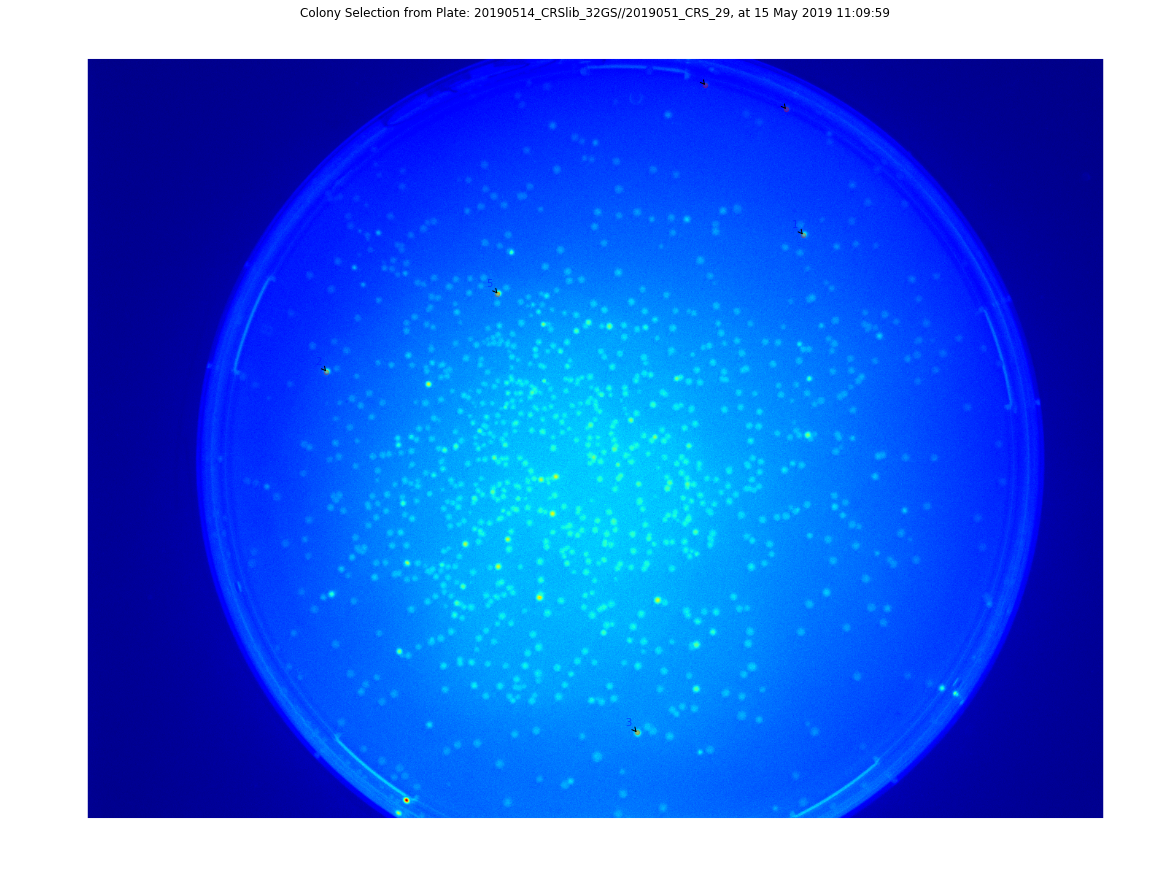

In [234]:
# Generate a picture of colonies with best locations marked
plt.figure(figsize=(20, 16))
plt.imshow(imageStack[0,:,:])
xs = []
ys = []
for i in range(6):
    xpos = scipy.ndimage.center_of_mass(imageStack[0,:,:], colonyAreaMask, sel[-1-i])[0]
    ypos = scipy.ndimage.center_of_mass(imageStack[0,:,:], colonyAreaMask, sel[-1-i])[1]
    xs.append(xpos)
    ys.append(ypos)
    plt.annotate(
        i+1,
        alpha=0.5,
        color = 'b',
        xy = (ypos,xpos), xytext = (-5, 5),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
c = plt.scatter(ys,xs, color = 'r')
c.set_alpha(0.25)
plt.axis("off")
plt.title('Colony Selection from Plate: ' + plate_name + ', at ' + datestr)
plt.savefig(plate_name + '_Colonies', papertype='A4')

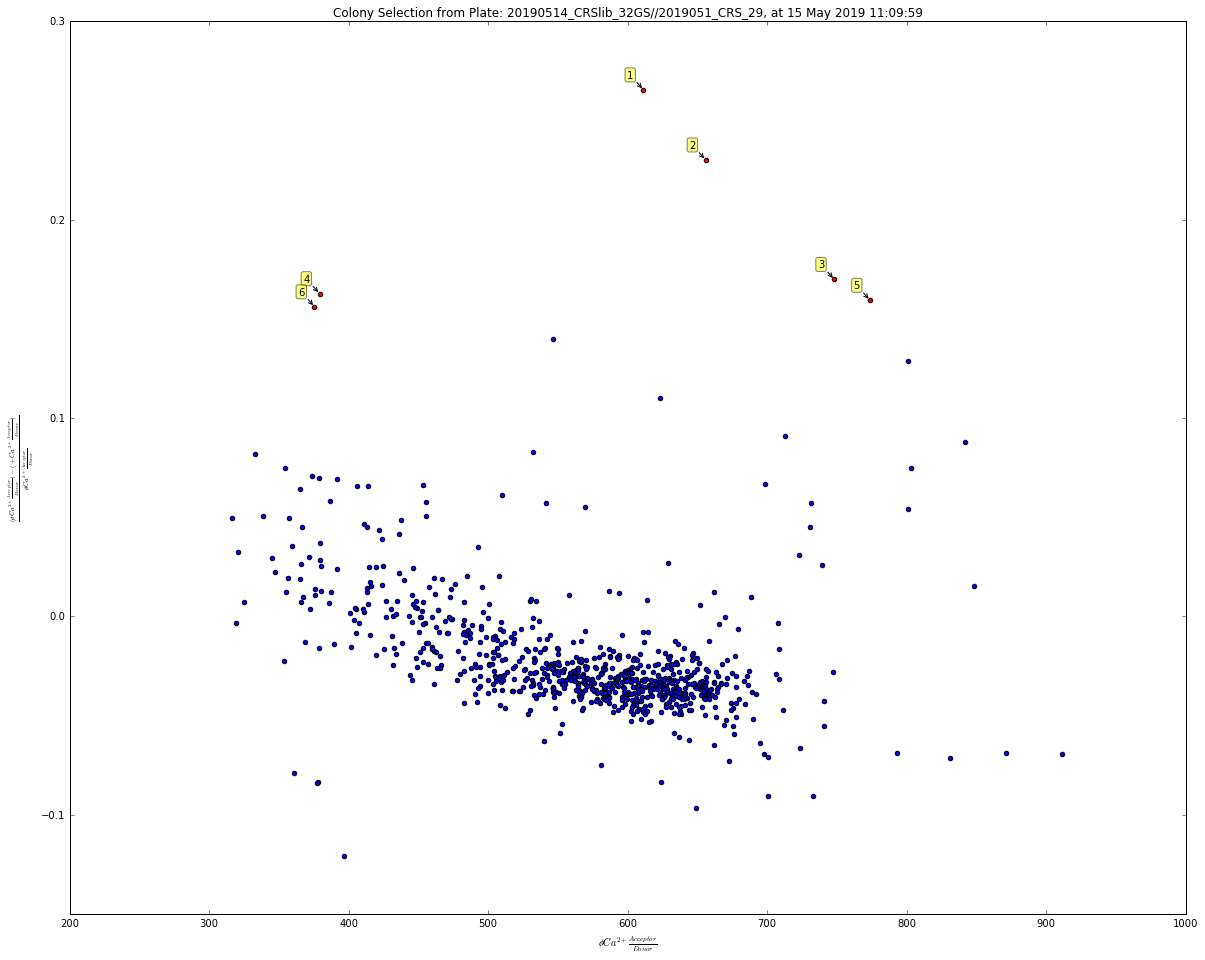

In [235]:
# Scatter plot of Calcium response, with the best ten colonies marked in red
plt.figure(figsize=(20, 16))
plt.scatter(startBrightness[sel[-6:]], (endBrightness[sel[-6:]]-startBrightness[sel[-6:]])/startBrightness[sel[-6:]], c = 'r')
plt.scatter(startBrightness[sel[0:-6]], (endBrightness[sel[0:-6]]-startBrightness[sel[0:-6]])/startBrightness[sel[0:-6]], c = 'b')
plt.title('Colony Selection from Plate: ' + plate_name + ', at ' + datestr)
plt.xlabel(r'$\o Ca^{2+}\frac{Acceptor}{Donor}$')
plt.ylabel(r'$\frac{(\o Ca^{2+}\frac{Acceptor}{Donor})-(+Ca^{2+}\frac{Acceptor}{Donor})}{\o Ca^{2+}\frac{Acceptor}{Donor}}$')
for i in range(6):
    plt.annotate(i+1, xy = (startBrightness[sel[-1-i]],(endBrightness[sel[-1-i]]-startBrightness[sel[-1-i]])/startBrightness[sel[-1-i]]), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.2', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.savefig(plate_name + '_Selection', papertype='A4')

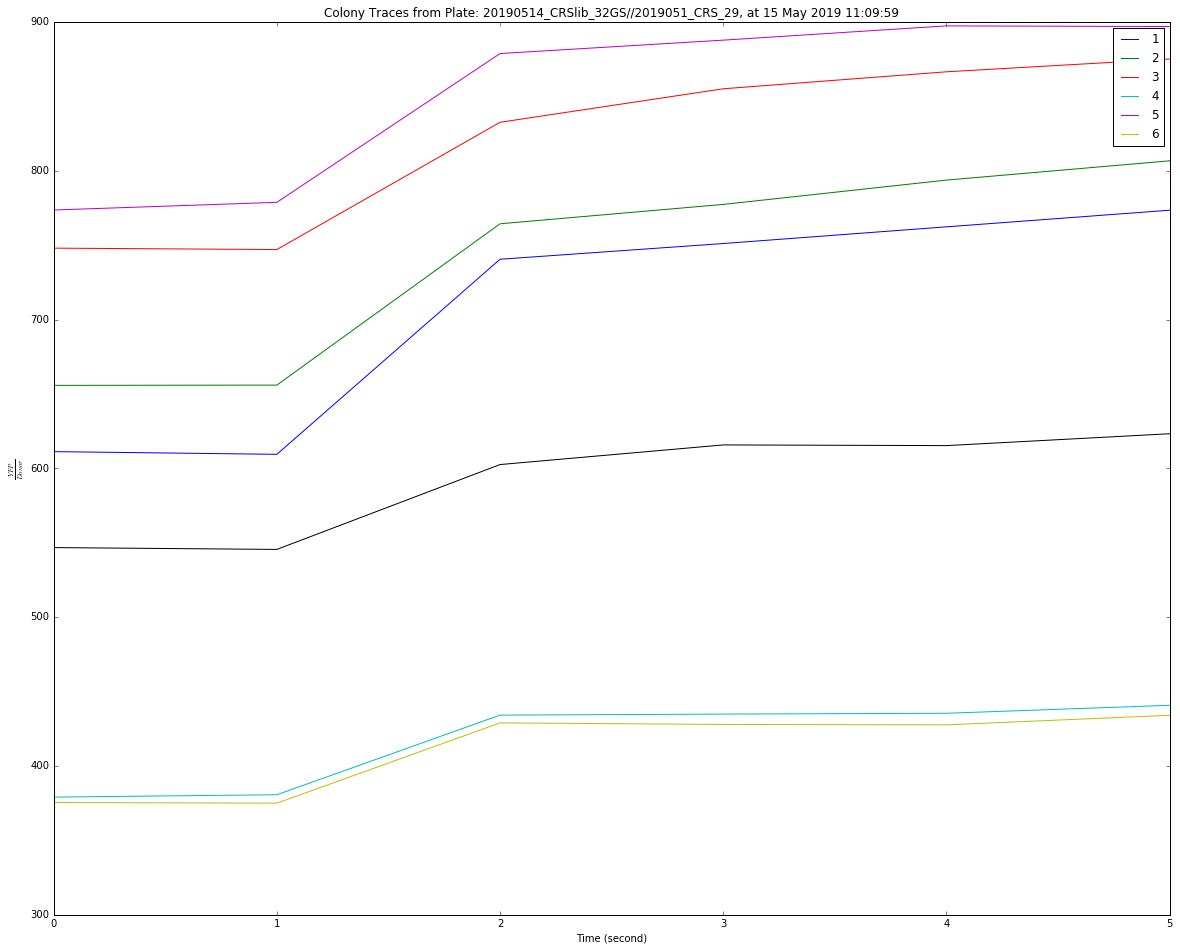

In [236]:
# Traces of Calcium response for the best ten colonies
plt.figure(figsize=(20, 16))
plt.plot(numpy.array([numpy.arange(0,numpy.shape(colonyData)[0],1),]*6).T,colonyData[:,sel[-1:-8:-1]] );
plt.legend( ('1', '2', '3', '4', '5','6') )
plt.title('Colony Traces from Plate: ' + plate_name + ', at ' + datestr)
plt.xlabel(r'Time (second)')
plt.ylabel(r'$\frac{YFP}{Donor}$')
plt.savefig(plate_name + '_Plot', papertype='A4')